# FunLearning

小学6年级作文写作训练

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
#import operator
#from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.memory import MemorySaver

#memory = SqliteSaver.from_conn_string(":memory:")
memory = MemorySaver()

In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [3]:
# 我们想跟踪如下信息：
# task, 代表用户输入，要求写一篇关于什么的作文。
# plan, LLM生成的作文提纲。
# draft, LLM生成的作文草稿。
# critique, LLM生成的对作文草案的改进意见。
# content，保存Tavily搜索到的与plan或critique相关的信息，注意，content的内容是具体的信息，而不是网址链接。
# revision_number，保存已经进行多少次修订。
# max_revisions，保存我们最多允许进行多少次修订。

# plan_node的作用： 根据task，由LLM生成作文提纲，更新plan键值。
# research_plan_node和research_critique_node的作用： LLM生成搜索query，然后通过调用Tavily工具查找作文大纲(plan)或改进意见(critique)相关资料，更新content键值。
# generation_node的作用： 用来由LLM生成作文草稿，更新draft和revision_number这2个键值。
# reflection_node的作用： 由LLM针对作文草稿生成改进意见，更新critique键值。
# 每次graph运行时，会传入用户要求写哪方面的作文，即task，更新task键值。同时也会初始化max_revisions和revision_number键值。

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(
    model_name='qwen2.5:32b',
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=True
)

In [5]:
PLAN_PROMPT = """你是一位小学6年级学生，男孩，擅长写作文，尤其擅长作文架构，现在你的任务是根据用户提供的作文主题，给出作文撰写提纲，并说明你这样设计作文提纲的理由。"""

In [6]:
WRITER_PROMPT = """你是一位小学6年级学生，男孩，擅长写作文，现在你的任务是撰写优秀的作文。根据用户提供的作文主题和初始大纲，写出尽可能好的作文，字数在600字左右。如果用户提供改进意见，请按改进意见进行修订。需要利用所有以下信息： 

------

{content}"""

In [7]:
REFLECTION_PROMPT = """你是一位小学6年级老师，负责批改一篇作文。请为该作文提出评价和改进建议。你的反馈应包含详细的建议，涉及作文的长度、深度、风格等方面的要求。"""

In [8]:
RESEARCH_PLAN_PROMPT = """你是一位研究人员，负责根据一个针对小学6年级作文大纲，生成一份搜索查询列表（最多生成3个查询），供Tavily搜索相关信息。"""


In [9]:
RESEARCH_CRITIQUE_PROMPT = """你是一位研究人员，根据用户提出的对一份小学6年级作文的改进意见，生成一份搜索查询列表（最多生成3个查询），供Tavily搜索相关信息。"""


In [10]:
# research plan或者research critique（通过LLM）将生成要搜索的内容的列表，传递给Tavily进行搜索，为此，我们将使用function call，
# 确保我们从LLM得到一个搜索列表。所以，我们使用Pydantic定义Queries类，确保我们从LLM得到的回复是字符串列表，即搜索列表。

from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

现在，我们开始创建所有不同的node。  

首先是plan node：

In [12]:
# plan Node要做的是接收state，创建一个消息列表。其中SystemMessage是plan prompt，HumanMessage是task，即要写关于哪方面的作文。
# 将消息列表传递给LLM，得到的response.content将作为plan返回。注意，这将会更新state的"plan"键值。
def plan_node(state: AgentState):
    # 创建一个消息列表，SystemMessage是PLAN_PROMPT，HumanMessage是"task"，即要生成关于哪方面的作文。
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]

    # 将消息列表传递给LLM，返回的response.content即LLM生成的作文写作大纲（plan）。
    response = model.invoke(messages)

    # 更新state “plan"键值。
    return {"plan": response.content}

In [13]:
# research plan node接收state，通过给model传递RESEARCH_PLAN_PROMPT和task，生成queries。
# 然后取得当前state的content，即之前已经有的参考内容。
# 然后对于每一个query，调用Tavily工具搜索，将搜索得到的参考内容追加到content中。
# 最后返回content，即参考内容列表。注意，这将更新state的"content"键值。
def research_plan_node(state: AgentState):

    # 创建包含RESEARCH_PLAN_PROMPT和"task"的消息列表，传递给LLM，LLM生成针对task的搜索queries。
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])

    # 取得当前已有的state "content"，赋值给content
    #content = state['content'] or []
    content = state.get('content', []) or []

    # 针对每一个query，使用Tavily进行搜索，得到的内容追加到content中。
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])

    # 更新state "content"键值。
    return {"content": content}

前面我们制定了一个plan，进行了一些research，现在可以写第一稿了：

In [14]:
def generation_node(state: AgentState):

    # 将所有state['content']连接在一起（注意，'content'是之前搜索到的所有具体内容，而不是网址链接），保存在content变量中。
    content = "\n\n".join(state['content'] or [])

    # 创建用户输入，包括了"task"（要写关于哪方面的作文） 和"plan"（作文写作大纲），
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")

    # 创建消息列表messages，其中SystemMessage是WRITER_PROMPT（包括research_plan_node通过Tavily搜索得到的相关资料）。
    # HumanMessage就是上面创建的user_message，包括"task"和"plan"。
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    
    # 将消息列表传递给LLM，得到的response.content就是LLM根据messages中的消息生成的作文草稿
    response = model.invoke(messages)

    # 更新state的"draft"和"revision_number"键值。
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


生成了作文草稿之后，我们需要对作文进行反思，生成对作文草稿的改进意见：

In [15]:
# reflection node对作文草稿进行反思，提出改进意见
def reflection_node(state: AgentState):
    # 创建消息列表，SystemMessage是反思提示词，HumanMessage是作文草稿。
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]

    # 将消息列表传递给LLM，得到的response.content即LLM对作文草稿的改进意见。
    response = model.invoke(messages)

    # 更新state的"critique"键值。
    return {"critique": response.content}

In [16]:
# research critique节点用于对改进意见进行研究，所以它和research plan node做的事情很类似。
def research_critique_node(state: AgentState):

    # 将改进意见和对应的RESEARCH_CRITIQUE_PROMPT传递给LLM，得到要做哪些queries。
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])

    # 取得当前state['content']，赋值给content变量
    # content = state['content'] or []
    content = state.get('content', []) or []

    # 针对每一条query，调用Tavily工具查询，查询结果追加到content中。
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])

    # 更新state "content"键值。
    return {"content": content}

我们还需要一个判断是否继续改进的函数should_continue。这个函数在generation_node后执行，所以generation_node后，要么END，表示得到作文终稿。要么执行"reflect"节点，继续对草稿提出改进意见，再按改进意见查询修改。

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

我们定义了所有需要的node以及条件，现在我们可以把它们组合成graph了：

In [18]:
# 创建graph
builder = StateGraph(AgentState)

In [19]:
# 添加节点
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [20]:
# 指定入口节点
builder.set_entry_point("planner")

In [21]:
# 添加条件边，生成作文草稿后，是继续修改还是作为终稿结束。
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [22]:
# 添加普通边
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [23]:
# 编译graph，编译完成后graph就是一个runnable，支持invoke, stream, batch等接口。
graph = builder.compile(checkpointer=memory)

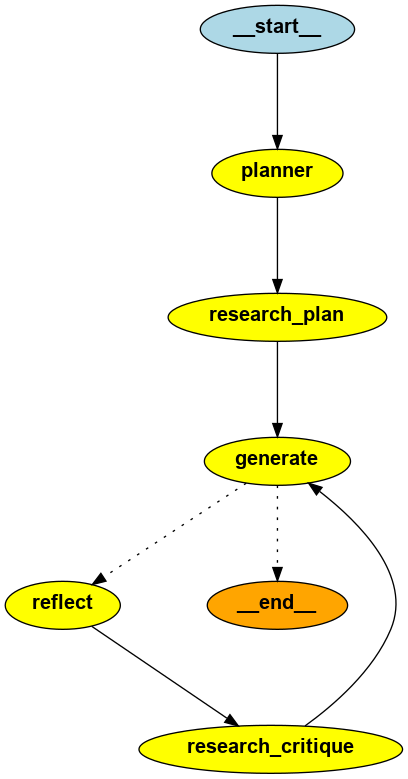

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
# 执行graph，传入task，同时指定max_revisions和revision_number。
# 从打印的信息可以看出，因为设置max_revisions为2，所以graph的执行经历了如下过程：
# 'planner'-->'research_plan'-->'generate'-->'reflect'-->'research_critique'-->'generate'

thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    #'task': "what is the difference between langchain and langsmith",
    'task': "我的一次期末考试",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)
    print("--------------------------------------------------------------")

{'planner': {'plan': '写作一篇题为“我的一次期末考试”的作文时，我们可以按照这样的提纲进行：\n\n### 一、引出话题\n#### 提纲要点：\n1. 简述平时学习生活的状态。\n2. 引入即将到来的期末考试，描述考前的心情（紧张、认真复习）。\n3. 创设情景或背景，如考前几天家里的安静氛围。\n\n**理由：通过描写日常学习生活使读者更容易理解作者对这次期末考试的态度与心境。**\n\n### 二、详细经过\n#### 提纲要点：\n1. 考试当天的路线（从家出发到学校的情景）。\n2. 实际进考场过程：心理状态，进入考室的感受和遇到的同学情况等。\n3. 具体某一场或几场考试的细节描述：拿到试卷时的状态；解题思路转换/障碍；以及自己努力答题的过程；遇到难题后的沉着思考或求助老师的心理活动。\n4. 简要概括每门课考试状况及成绩期望。\n\n**理由：详细过程能使读者更真实地感受作者参加期末考的情境与心路变迁，尤其是对某一环节的深入分析能展示“你”面对重要关卡时的心态变化。**\n\n### 三、总结感想\n#### 提纲要点：\n1. 考试结束后的心情（放松或者忐忑不安等待成绩）。\n2. 对此次考试结果的看法（意外的结果/达到既定目标）。\n3. 分享一下个人在未来学习中的计划与态度改变，包括怎样去改进方法、调整心态。\n\n**理由：这部分是作文的升华阶段，通过总结这次经历给自己带来的经验和教训，有助于启发自己同时也为其他人提供积极正面的信息。**\n\n这样的提纲结构可以帮助你清晰有序地描述“我的一次期末考试”，使得文章既有叙述上的连贯性又容易引起读者共鸣与思考。'}}
--------------------------------------------------------------


/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['期末考试作文 8. 还有二十天就要期末考试了，老妈现在就让我开始总体复习了，不准玩电脑游戏，除非打博客，不准看动画片，而且还要还有定时间，几点干什么几点干什么不过这也都是为了我考好成绩才这样干的。 就说今天中午放学吧!', '今天王老师给同学们准备了小学六年级语文下册常考的6大作文素材积累，一定要收藏! 1. 人生哲理 （关于人生、生活、生命、成长等）. 1、人生似一束鲜花，仔细观赏，才能看到它的美丽；人生似一杯清茶，细细品味，才能赏出真味道。', '在平日的学习、工作和生活里，大家最不陌生的就是作文了吧，借助作文可以宣泄心中的情感，调节自己的心情。那么你知道一篇好的作文该怎么写吗？ 期末作文400字 1. 平时最怕考试，因为什么都不擅长，所以只能看一门数学。听说要期中考试，差点没吓死。', '在现实生活或工作学习中，大家都跟作文打过交道吧，作文是人们把记忆中所存储的有关知识、经验和思想用书面形式表达出来的记叙方式。相信许多人会觉得作文很难写吧，下面是小编帮大家整理的六年级期末考试作文，仅供参考，欢迎大家阅读。 六年级期末考试作文 篇1 当我拿到四张充满了红', '学生是否愿意配合？其他班的考试情况？ ... 高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命。 ... 如何进行小学六年级语文期中考试的自我反思？', '小学 6年级，为了应对这次期末考，充分调动孩子们复习的积极性，老师们又放大招：考好者，重赏神秘大礼包，这个相当有吸引力，我家孩子这几天为了背语文复习资料，一直想着早上5：30起床，要知道她以前都快7点了，叫还叫不醒。']}}
--------------------------------------------------------------
{'generate': {'draft': '### 我的一次期末考试\n\n在平时的学习生活中，我一直按照自己的节奏前进，每天的课程如常进行，在知识的世界里探索着未知的秘密。然而随着考试的临近，我变得越来越专注和认真。我的妈妈见状也加强了对学习计划的要求，每天都安排得井井有条，严格控制游戏时间，确保我能把全部注意力都放在学习上。\n\n尤其是在考前

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_critique': {'content': ['期末考试作文 8. 还有二十天就要期末考试了，老妈现在就让我开始总体复习了，不准玩电脑游戏，除非打博客，不准看动画片，而且还要还有定时间，几点干什么几点干什么不过这也都是为了我考好成绩才这样干的。 就说今天中午放学吧!', '今天王老师给同学们准备了小学六年级语文下册常考的6大作文素材积累，一定要收藏! 1. 人生哲理 （关于人生、生活、生命、成长等）. 1、人生似一束鲜花，仔细观赏，才能看到它的美丽；人生似一杯清茶，细细品味，才能赏出真味道。', '在平日的学习、工作和生活里，大家最不陌生的就是作文了吧，借助作文可以宣泄心中的情感，调节自己的心情。那么你知道一篇好的作文该怎么写吗？ 期末作文400字 1. 平时最怕考试，因为什么都不擅长，所以只能看一门数学。听说要期中考试，差点没吓死。', '在现实生活或工作学习中，大家都跟作文打过交道吧，作文是人们把记忆中所存储的有关知识、经验和思想用书面形式表达出来的记叙方式。相信许多人会觉得作文很难写吧，下面是小编帮大家整理的六年级期末考试作文，仅供参考，欢迎大家阅读。 六年级期末考试作文 篇1 当我拿到四张充满了红', '学生是否愿意配合？其他班的考试情况？ ... 高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命。 ... 如何进行小学六年级语文期中考试的自我反思？', '小学 6年级，为了应对这次期末考，充分调动孩子们复习的积极性，老师们又放大招：考好者，重赏神秘大礼包，这个相当有吸引力，我家孩子这几天为了背语文复习资料，一直想着早上5：30起床，要知道她以前都快7点了，叫还叫不醒。', '六年级是小学阶段的最后一年，作文写作作为语文学习的重要组成部分，对学生的综合素质和语文能力提出了较高的要求。 ... 生动的语言能够使文章更加有趣、更具吸引力。 ... 同学们可以多读一些优秀的范文和文学作品，学习别人的写作技巧和表达方式；同时', '这些目标能够 帮助学生保持写作的动力和方向。 通过这些方法的应用，小学六年级的学生们将能够在作文写 作上取得显著的进步。不仅能提升他们的语言表达能力，还能增 强他们的自信心，使他们在未来的学习和生活中能够更自如地运 用写作

## Essay Writer Interface

In [26]:
import warnings
warnings.filterwarnings("ignore")

from FunLearning import writer, writer_gui

In [27]:
MultiAgent = writer()
app = writer_gui(MultiAgent.graph)
app.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/gradio/queueing.py", line 622, in process_events
    response = await route_utils.call_process_api(
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/gradio/blocks.py", line 2014, in process_api
    result = await self.call_function(
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/gradio/blocks.py", line 1567, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2461, in ru